<a href="https://colab.research.google.com/github/patrickbryant1/EvoBind/blob/master/EvoBind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EvoBind
EvoBind designs peptide binders towards user-specified target residues - or **completely blind** - using only sequence information.

EvoBind accounts for adaptation of the receptor interface structure to the peptide design during optimisation. This consideration of flexibility is crucial for binding.

EvoBind2 is based on AlphaFold2, which is available under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0).  \
The AlphaFold2 parameters are made available under the terms of the [CC BY 4.0 license](https://creativecommons.org/licenses/by/4.0/legalcode) and have not been modified.
\
The design protocol EvoBind2 is made available under the terms of the [CC BY-NC 4.0 license](https://creativecommons.org/licenses/by-nc/4.0/). \
**You may not use these files except in compliance with the licenses.**

## Local installation
For local installation of EvoBind see: https://github.com/patrickbryant1/EvoBind

If you like EvoBind - **please star the repo!**

## Citation
If you use EvoBind, please cite:

**Li, Q., Vlachos, E.N. & Bryant, P. Design of linear and cyclic peptide binders from protein sequence information. Commun Chem 8, 211 (2025). https://doi.org/10.1038/s42004-025-01601-3**
[Link to paper](https://www.nature.com/articles/s42004-025-01601-3)

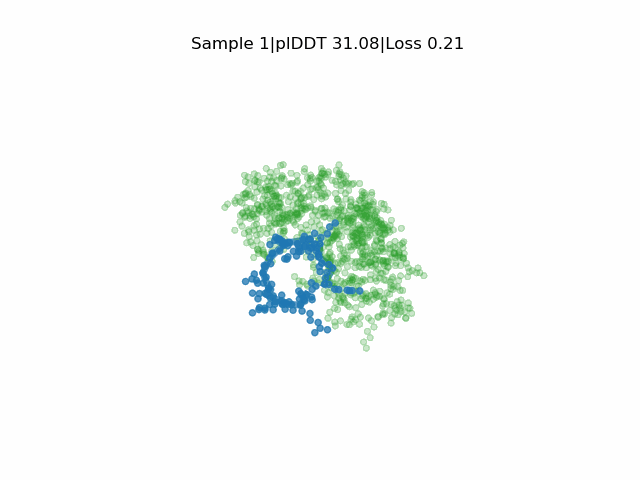

In [ ]:
#@title Install dependencies
#@markdown Make sure your runtime is GPU.
#@markdown In the menu above do: Runtime --> Change runtime type --> Hardware accelerator (set to GPU)

#@markdown **Press play.**

#@markdown Simply press play on each cell below and follow the instructions.
#@markdown The installation takes a few minutes.

#@markdown After it finishes (the play button wheel stops spinning) do: Runtime > Restart session (above).

!pip install -q --no-warn-conflicts dm-haiku==0.0.11
!pip install -q --no-warn-conflicts ml-collections
!pip install -q --no-warn-conflicts biopython==1.81
!pip install -q --no-warn-conflicts chex==0.1.5
!pip install -q --no-warn-conflicts dm-tree==0.1.8
!pip install -q --no-warn-conflicts immutabledict==2.0.0
!pip install -q --no-warn-conflicts scipy==1.7.3
!pip install -q --no-warn-conflicts tensorflow==2.11.0
!pip install -q --no-warn-conflicts rdkit-pypi
!pip install -q --no-warn-conflicts py3Dmol
!pip install -q --no-warn-conflicts numpy==1.26.4
!pip uninstall -y jax jaxlib
!pip install -q  --no-warn-conflicts jaxlib==0.4.35
!pip install -q --no-warn-conflicts 'jax[cuda12_pip]'==0.4.35 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html





In [ ]:
#@title Clone the EvoBind github repo
import shutil
try:
  shutil.rmtree('/content/EvoBind', ignore_errors=True)
except:
  print('')

!git clone https://github.com/patrickbryant1/EvoBind.git

In [2]:
#@title #Follow all steps outlined below to design a binder.
#@markdown To try the **test case** [1ssc](https://www.rcsb.org/3d-view/1SSC), press the play button to the left.
\
#@markdown If you don't want to run the test case, **change the input parameters**.

#@markdown #Parameters
#@markdown - *PDBID* - PDB id of the receptor structure
#@markdown - *RECEPTOR_CHAIN* - what chain in the PDB file to use as receptor
#@markdown - **Optional**: *UPLOAD_PDB* - if you prefer to upload a file instead, you can simply do this. See "Upload the MSA" below and ensure the PDBID matches the name of your uploaded file.
#@markdown - *RECPTOR_SEQUENCE* - amino acid sequence of the receptor protein chain
#@markdown - **Optional**: *TARGET_RESIDUES* - what residue numbers in the receptor sequence to design a binder towards. Separated by commas.
#@markdown If not provided, EvoBind will pick a binding spot.
#@markdown - *BINDER_LENGTH* - should be <20 residues
#@markdown - **Optional**: *START_SEQUENCE* - sequence to start the optimisation from. If no sequence is provided, a random sequence is initialised. If you don't have a good start sequence, leave this empty. If you want to simply predict a protein-peptide interaction, input a start sequence and set NITER to 1, then download the result below.
#@markdown - *NITER: Number of iterations* - how many iterations to optimise (default=300)
#@markdown - **Optional:** CYCLIC_OFFSET - design a cyclic peptide binder.
#@markdown - **Receptor MSA** - currently no MSA search is available directly in this notebook, therefore you have to provide your own MSA in a3m format and upload it here. \
#@markdown There are two ways of doing this: \
#@markdown 1. Search uniclust_30 locally with HHblits \
#@markdown 2. Go to https://toolkit.tuebingen.mpg.de/tools/hhblits \
#@markdown Paste the receptor sequence in the search field in fasta format --> Submit. \
#@markdown When the search is finished, go to the tab "Query MSA" and "Download Full A3M" \
#@markdown - Upload the MSA here: \
#@markdown Click the folder icon (Files) to the left and select the upload file icon. Upload the .a3m file.
#@markdown Make sure the MSA is named **PDBID**_receptor.a3m, where PDBID is the PDBID specified above.
import sys, os
from google.colab import files
import pandas as pd
import numpy as np
import urllib.request
import py3Dmol
import matplotlib.pyplot as plt
import glob
sys.path.insert(0,'/content/EvoBind/src')
PDBID = "1ssc" #@param {type:"string"}
RECEPTOR_CHAIN = "A" #@param {type:"string"}
UPLOAD_PDB = False # @param {type:"boolean"}
RECEPTOR_SEQUENCE = "KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEG" #@param {type:"string"}
TARGET_RESIDUES = "" #@param {type:"string"}
if len(TARGET_RESIDUES)<1:
  TARGET_RESIDUES=np.arange(len(RECEPTOR_SEQUENCE))
else:
  TARGET_RESIDUES = [int(x) for x in TARGET_RESIDUES.split(',')]
BINDER_LENGTH =  8#@param {type:"integer"}
START_SEQUENCE = "PDERCNGV" #@param {type:"string"}
NITER =  300#@param {type:"integer"}
CYCLIC_OFFSET = True # @param {type:"boolean"}
RECEPTOR_MSA = "1ssc_receptor.a3m" #@param {type:"string"}
OUTDIR="/content/"+PDBID+'/'
#Make outdir
if not os.path.exists(OUTDIR):
  os.mkdir(OUTDIR)
#Get structure
RECEPTOR_STRUCTURE = "https://files.rcsb.org/download/"+PDBID

#Try .pdb
if UPLOAD_PDB==True:
  RECEPTOR_STRUCTURE='/content/'+PDBID+'.pdb'
else:
  if not os.path.exists(OUTDIR+PDBID+".pdb"):
    try:
      urllib.request.urlretrieve(RECEPTOR_STRUCTURE+".pdb", OUTDIR+PDBID+".pdb")
    except:
      print('')
  #Otherwise .cif
  if not os.path.exists(OUTDIR+PDBID+".pdb") and not os.path.exists(OUTDIR+PDBID+".cif"):
    try:
      urllib.request.urlretrieve(RECEPTOR_STRUCTURE+".cif", OUTDIR+PDBID+".cif")
    except:
      print("Can't download file: "+RECEPTOR_STRUCTURE+'. Ensure that the PDBID is correct.')

  if len(glob.glob(OUTDIR+PDBID+".pdb"))>0:
    RECEPTOR_STRUCTURE=OUTDIR+PDBID+".pdb"
  else:
    RECEPTOR_STRUCTURE=OUTDIR+PDBID+".cif"

#Read and display the PDB file
sys.path.insert(0,'/content/EvoBind/src/')
from prepare_input_colab import prepare_input
#Get the receptor CAs
RECEPTOR_CAs, RECEPTOR_PDBSEQ = prepare_input(RECEPTOR_STRUCTURE, RECEPTOR_CHAIN, TARGET_RESIDUES, OUTDIR)

#Print the receptor PDB sequence
print('The receptor sequence according to the specified PDB file is:',RECEPTOR_PDBSEQ)
print('Make sure this is the sequence you are using for the MSA as well.')
#Check the sequence and structure
if RECEPTOR_SEQUENCE!=RECEPTOR_PDBSEQ:
  print('ERROR!')
  print('The specified sequence and the sequence in the PDB file are not identical.')
  print('Specified sequence:', RECEPTOR_SEQUENCE)
  print('PDB sequence', RECEPTOR_PDBSEQ)
else:
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(OUTDIR+"receptor.pdb",'r').read(),'pdb')
  view.setStyle({'chain':'A'},{'cartoon': {'color':'green'}})
  view.addModel(open(OUTDIR+"receptor_target_residues.pdb",'r').read(),'pdb')
  view.setStyle({'chain':'B'},{'stick':{}})
  view.zoomTo()
  view.show()

#Check the MSA
if PDBID=='1ssc':
  RECEPTOR_MSA = '/content/EvoBind/data/test/'+RECEPTOR_MSA
else:
  RECEPTOR_MSA ='/content/'+RECEPTOR_MSA
if not os.path.exists(RECEPTOR_MSA):
  print("Can't find MSA:",RECEPTOR_MSA)
else:
  print('Using MSA:',RECEPTOR_MSA)

from check_msa_colab import process_a3m
PROCESSED_MSA=RECEPTOR_MSA.split('.')[0]+'_processed.a3m'
process_a3m(RECEPTOR_MSA, RECEPTOR_SEQUENCE, PROCESSED_MSA)
RECEPTOR_MSA=PROCESSED_MSA
#Write fasta
RECEPTOR_FASTA=OUTDIR+PDBID+'_receptor.fasta'
with open(RECEPTOR_FASTA, 'w') as file:
  file.write('>'+PDBID+'\n')
  file.write(RECEPTOR_SEQUENCE)

#Check the start sequence length
if len(START_SEQUENCE)>0:
  if len(START_SEQUENCE)!=BINDER_LENGTH:
    print('The starting sequence length does not match the binder length')

#@markdown ----
#@markdown \
#@markdown ### The receptor is depicted in green in cartoon format and the target residues in grey stick format.

The receptor sequence according to the specified PDB file is: KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEG
Make sure this is the sequence you are using for the MSA as well.


/usr/local/lib/python3.12/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1290.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1382.
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Using MSA: /content/EvoBind/data/test/1ssc_receptor.a3m


In [ ]:
#@markdown #Run *EvoBind*

#@markdown Click play to design a binder.

#@markdown The whole process will take approximately **7 hours** (for 300 iterations). Relax and wait for your binder.
#@markdown The run will continue where you left it if it was interrupted for some reason.

#@markdown The iteration, interface distance for the peptide, interface distance for the receptor, plDDT, delta COM, loss and best peptide sequence are displayed after each iteration.

#@markdown The AF2 params are fetched here (if they are not already downloaded).
import shutil
import collections
collections.Iterable = collections.abc.Iterable

PARAMS="/content/AF/params/"
if not os.path.exists(PARAMS):
  if not os.path.exists('/content/AF/'):
    os.mkdir('/content/AF/')
  os.mkdir(PARAMS)
  !wget https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
  shutil.move('/content/alphafold_params_2021-07-14.tar', PARAMS)
  #Extract
  !tar -xvf /content/AF/params/alphafold_params_2021-07-14.tar -C /content/AF/params/
sys.path.insert(0,'/content/EvoBind/src/AF2')


from mc_design_colab import main
MAX_RECYCLES=8 #max_recycles (default=3)
MODEL_NAME='model_1' #model_1_ptm
main(RECEPTOR_FASTA, 'design', TARGET_RESIDUES,
     RECEPTOR_MSA, BINDER_LENGTH,
     OUTDIR, NITER,
     [MODEL_NAME], MAX_RECYCLES, "/content/AF/",
     CYCLIC_OFFSET, START_SEQUENCE)

In [ ]:
#@markdown #Analyse the results
#@markdown The TOP_FRACTION represents how many percent of the designs to select.

#@markdown Only the best model is visualised. As a rule of thumb, a **plDDT value above 90** represents a reliable binder.

#@markdown Click the DOWNLOAD box to download the top models and their sequences.

#@markdown Click the DOWNLOAD_START box to download the start model.
import pandas as pd
TOP_FRACTION =  100#@param {type:"integer"}
RECEPTOR_STYLE = "stick" #@param ["cartoon", "sphere", "stick"]
BINDER_STYLE = "stick" #@param ["cartoon", "sphere", "stick"]
DOWNLOAD = False #@param {type:"boolean"}
DOWNLOAD_START = False #@param {type:"boolean"}
metrics = pd.read_csv(OUTDIR+'designmetrics.csv')
#Get top
metrics = metrics.sort_values(by='loss').reset_index()
n_select = int(TOP_FRACTION/100*len(metrics))
top_sel = metrics.loc[:n_select]

top_loss = top_sel.loss.values
top_sequence = top_sel.sequence.values
top_plddt = top_sel.plddt.values
top_models = top_sel.iteration.values

#Print
print('The best sequences, losses and plDDT values are:')
for i in range(len(top_loss)):
  print(top_sequence[i], top_loss[i], top_plddt[i])
#Vis
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
top_model = top_models[0]
if top_model=='init':
  model_path = OUTDIR+'/design/unrelaxed_start.pdb'
else:
  model_path = OUTDIR+'/design/unrelaxed_'+str(top_model)+'.pdb'
view.addModel(open(model_path,'r').read(),'pdb')
view.setStyle({'chain':'A'},{RECEPTOR_STYLE: {'color':'green'}})
view.setStyle({'chain':'B'},{BINDER_STYLE: {'color':'cyan'}})
view.zoomTo()
view.show()

#@title Download the results
import shutil
if not os.path.exists(OUTDIR+'best_models'):
  os.mkdir(OUTDIR+'best_models')

#Download
if DOWNLOAD==True:
  rank=1
  for model in top_models:
    if model=='init':
      model_path = OUTDIR+'/design/unrelaxed_start.pdb'
    else:
      model_path = OUTDIR+'/design/unrelaxed_'+str(top_model)+'.pdb'

    shutil.copy(model_path, OUTDIR+'best_models/rank_'+str(rank)+'.pdb')
    rank+=1

  for file in glob.glob(OUTDIR+'best_models/rank_*.pdb'):
    files.download(file)

  #Write a fasta file with the top seqs
  rank=1
  with open(OUTDIR+'best_models/top_seqs.fasta', 'w') as file:
    for seq in top_sequence:
      file.write('>rank_'+str(rank)+'\n')
      file.write(seq+'\n')
      rank+=1
  files.download(OUTDIR+'best_models/top_seqs.fasta')

if DOWNLOAD_START==True:
  files.download(OUTDIR+'/design/unrelaxed_start.pdb')
#@markdown ### The receptor is depicted in green and the binder in cyan. Change the style above to view the design differently.
#@markdown ### Try the sphere representation to see how all atoms fit together.

The best sequences, losses and plDDT values are:
PDERCNGV 0.0434087466253819 91.4514010588034
ADERCNGV 0.0496420262873788 80.5795584888723
PDERCNGS 0.1301344077943975 39.05690593097096


3Dmol.js failed to load for some reason. Please check your browser console for error messages.